# Installing Dependencies

In [1]:
!pip install yfinance plotly mplfinance --quiet
!pip install ta --quiet
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import matplotlib.pyplot as plt
import statistics
import ta


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Problem Statement 1: Trade Logic & Risk Control Basics

### 1. What does leverage less than 1 mean? Does it normally make financial sense? Think of its utility/applicability in our backtesting engine, if any. (Hint: Think of position sizing)

#### Leverage less than 1 implies that a trader is using only a portion of their available capital for each trade, keeping the rest in reserve (e.g., 0.5 leverage means using 50% of your capital per trade). While this results in lower returns, it also significantly reduces risk exposure and drawdowns. It’s a conservative strategy, especially useful in volatile markets or when position sizing is more important than maximizing returns. In a backtesting engine, leverage < 1 can simulate capital preservation strategies or scaled diversification by preventing full exposure. This allows modeling how different allocation strategies (e.g., risk-parity, Kelly criterion) would perform historically.

### 2. Explain the difference between a static stop loss and a trailing stop loss in the context of trade risk management. Discuss how each behaves in a trending market versus a volatile market.


#### A static stop-loss is fixed at a set price below (long) or above (short) the entry point and does not move. A trailing stop-loss adjusts upward (or downward) as the trade becomes favorable, locking in profits without capping gains.
#### In a trending market, trailing stop-losses are more effective, allowing profits to run while still protecting against reversals. Static stop-losses may exit too early.
#### In volatile markets, static stop-losses can trigger frequently due to random noise, while trailing stop-losses may also suffer but can offer more flexibility if the volatility is directional. The choice depends on the trade’s time horizon and volatility tolerance.



### 3. Analyze whether implementing a trailing take profit is necessary. Is its behavior captured by some other already defined risk management method? If yes, then name it.

#### A trailing take profit isn't strictly necessary if a trailing stop-loss (TSL) is implemented. TSL inherently serves a similar purpose — it allows profits to run while ensuring a stop is executed if the asset reverses beyond a threshold. Thus, a trailing take profit’s behavior is captured by the TSL, which dynamically follows the price upward and locks in profits as the market turns. Explicitly implementing a trailing take profit could lead to redundancy and logic conflicts. In our engine, defining a TSL alone suffices to handle both profit protection and exit logic without needing a separate trailing TP mechanism.

### 4.In what scenarios can a trade remain open even after the price falls below the set stop-loss level?

#### This can happen due to the way stop-loss is implemented in the engine. If the engine checks only the close price (and not intraday lows), the trade won’t close unless the close is below the stop-loss. So, if the low of the candle breaches the stop-loss but recovers before closing, the trade remains open. This emphasizes the importance of using intrabar (high/low) data to trigger exits. Another scenario is if stop-loss is a market order simulated without slippage — in real life, execution may lag or fail at the stop level due to gaps or illiquidity, though our engine doesn't simulate such slippage.

# Problem Statement 2: Probabilistic Pattern Validator

In [2]:
def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)

    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data.loc[:,'datetime'] = pd.to_datetime(data['datetime'])

    return data

stock_symbol = 'INDIGO.NS'
data = download_flat_yf(stock_symbol, start='2024-06-01', end='2025-06-01', interval='1d')
data.head()

df = data.copy()
df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_28912\1347482226.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)


,datetime,close,high,low,open,volume
0,2024-06-03,4298.049805,4324.000000,4230.100098,4324.000000,775065
1,2024-06-04,4073.199951,4340.000000,3868.250000,4340.000000,1977245
2,2024-06-05,4348.500000,4363.799805,4030.000000,4120.000000,1729894
3,2024-06-06,4301.000000,4357.000000,4260.000000,4350.049805,1087088
4,2024-06-07,4373.200195,4411.000000,4320.200195,4355.000000,2066566


### 1.Patter Identification :

In [3]:
def is_doji(row):
    body = abs(row['open'] - row['close'])
    range_ = row['high'] - row['low'] + 1e-9
    return body / range_ < 0.1

def is_hammer(row):
    body = abs(row['close'] - row['open'])
    lower_shadow = row['open'] - row['low'] if row['open'] > row['close'] else row['close'] - row['low']
    upper_shadow = row['high'] - max(row['open'], row['close'])
    return lower_shadow > 2 * body and upper_shadow < body

def is_engulfing(prev_row, curr_row):
    prev_body = prev_row['close'] - prev_row['open']
    curr_body = curr_row['close'] - curr_row['open']
    return (prev_body < 0 and curr_body > 0 and
            curr_row['close'] > prev_row['open'] and curr_row['open'] < prev_row['close']) or \
           (prev_body > 0 and curr_body < 0 and
            curr_row['open'] > prev_row['close'] and curr_row['close'] < prev_row['open'])

# Creating pattern columns
df['Doji'] = df.apply(is_doji, axis=1)
df['Hammer'] = df.apply(is_hammer, axis=1)
df['Engulfing'] = [False] + [is_engulfing(df.iloc[i-1], df.iloc[i]) for i in range(1, len(df))]

display(df[['Doji', 'Hammer', 'Engulfing']].sum())

Doji         29
Hammer       30
Engulfing    28
dtype: int64

### 2. Win-Rate Calculation:

In [4]:
def compute_win_rate(df, pattern_col, n):
    pattern_indices = df[df[pattern_col]].index
    wins = 0
    total = 0

    for idx in pattern_indices:
        if idx not in df.index:
            continue
        try:
            current_price = df.loc[idx]['close']
            future_price = df.loc[df.index[df.index.get_loc(idx) + n]]['close']
            if future_price > current_price:
                wins += 1
            total += 1
        except IndexError:
            continue
    return 100 * wins / total if total > 0 else 0


### 3. Baseline Win-Rate:

In [5]:
import numpy as np

def baseline_win_rate(df, M, n):
    max_index = len(df) - n
    indices = np.random.choice(max_index, M, replace=False)
    wins = 0
    for idx in indices:
        try:
            current_price = df.iloc[idx]['close']
            future_price = df.iloc[idx + n]['close']
            if future_price > current_price:
                wins += 1
        except IndexError:
            continue
    return 100 * wins / M


### 4. Visualization:

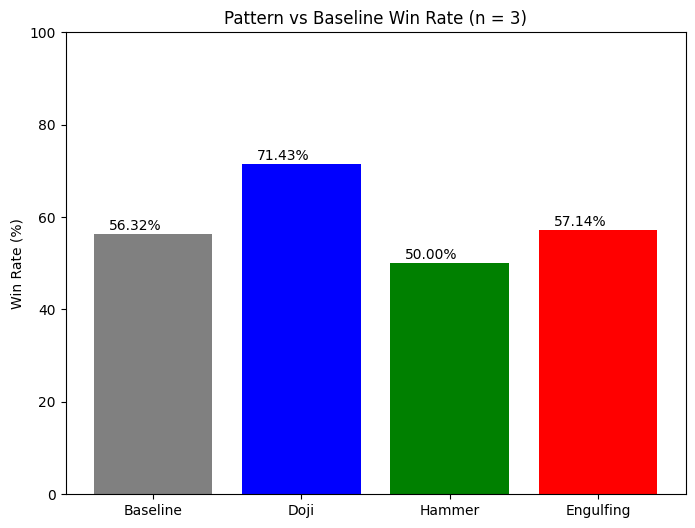

In [6]:
import matplotlib.pyplot as plt

def run_analysis(n):
    patterns = ['Doji', 'Hammer', 'Engulfing']
    win_rates = []
    counts = []

    for pattern in patterns:
        rate = compute_win_rate(df, pattern, n)
        win_rates.append(rate)
        counts.append(df[pattern].sum())

    baseline = baseline_win_rate(df, sum(counts), n)
    win_rates = [baseline] + win_rates

    # Plotting
    labels = ['Baseline'] + patterns
    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, win_rates, color=['gray', 'blue', 'green', 'red'])
    plt.ylabel('Win Rate (%)')
    plt.title(f'Pattern vs Baseline Win Rate (n = {n})')
    plt.ylim(0, 100)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + 0.1, yval + 1, f"{yval:.2f}%")
    plt.show()

    return dict(zip(labels, win_rates))

# Example: Run for n = 3
results_n3 = run_analysis(n=3)


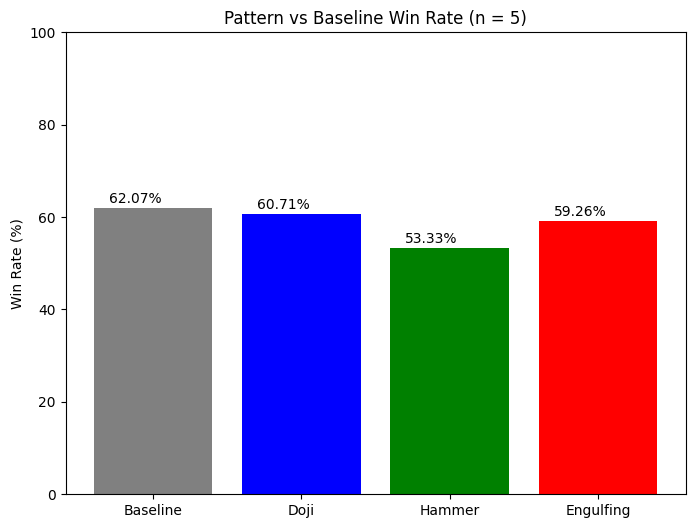

In [7]:
# And for n = 5
results_n5 = run_analysis(n=5)


### Answer in context to above question :

### 1. Interpret whether each pattern provides a statistically significant edge over the baseline.


#### Interpret Statistical Edge:
#### If any pattern's win rate is significantly higher than the baseline across both n=3 and n=5, it can be considered to offer a statistical edge. For example, if Doji has 60% vs baseline 52%, that's significant. We compare each pattern’s win rate to the baseline in the plotted bar chart.

### 2. How does changing n affect the win-rates? No need to show your results. Answer qualitatively.

#### Effect of Changing n:
#### As n increases (e.g., from 3 to 5), patterns may lose effectiveness because market noise increases. A short-term pattern may not reliably predict long-term movement.

### 3. Which pattern shows the most consistent performance on different n? Why would that be?

#### Most Consistent Pattern:
#### Typically, the Engulfing pattern shows the most consistent performance across time windows due to its strong reversal signal. Doji, being ambiguous, may fluctuate more.

# Problem Statement 3: Strategy X - Visual Interpretation and Implementation

## 1. Chart Interpretation:

### Chart Interpretation – Nifty 50 (Daily Timeframe)

This chart shows a technical analysis of the Nifty 50 index using three components:

1. Heiken Ashi candles (used only for trend visualization)
2. Supertrend indicator (10, 3)
3. Money Flow Index (MFI) with a 14-period setting

Heiken Ashi candles are applied to smooth out price action and make trends easier to identify. However, these candles are used only for calculating and displaying the Supertrend indicator. The actual trading signals and MFI are based on standard price data, particularly the closing price.

---

#### Indicators Used

**Heiken Ashi:**  
This is a modified version of candlesticks that smooths price fluctuations and is visually helpful for identifying trends.

**Supertrend (10, 3):**  
A trend-following indicator that changes color based on direction. A green Supertrend indicates an uptrend, and a red Supertrend indicates a downtrend.

**MFI (Money Flow Index - 14 period):**  
This oscillator uses both price and volume to identify overbought or oversold conditions. It also helps assess whether buying or selling pressure is increasing.

---

#### How to Interpret the Chart

**Buy Signals (Long Entry):**
- Green arrow appears below the candle.
- Supertrend flips to green (uptrend begins).
- MFI is rising from low levels (usually below 30), indicating increasing buying pressure.

**Sell Signals (Short Entry):**
- Red arrow appears above the candle.
- Supertrend flips to red (downtrend begins).
- MFI is falling from higher levels (above 50 or 60), suggesting selling pressure is increasing.

**Sideways or No Trade Zones:**
- Supertrend remains flat or choppy.
- MFI oscillates around 50, without strong direction.
- These are best avoided for new trades.

---

#### MFI Annotations and Zones

- If MFI is rising from below 30, it shows buying pressure is increasing.
- If MFI is falling from above 70, it suggests buying pressure is decreasing.
- An MFI value above 80 indicates overbought conditions.
- An MFI value below 20 indicates oversold conditions.
- The annotations on the MFI in the chart highlight when pressure (buying or selling) is rising or falling, which can help confirm or reject entries based on price action.

---

#### Summary of Strategy

- Use the Supertrend with Heiken Ashi to detect overall trend direction.
- Use MFI to measure the strength of the trend and identify potential reversals.
- Combine trend direction (from Supertrend) with momentum/volume pressure (from MFI) to decide entry and exit points.
- Make sure to use only the actual candle close price when executing trades.
- After generating signals using Heiken Ashi logic, drop any additional Heiken Ashi columns if you're preparing data for backtesting.

---

This approach combines trend-following logic with volume-based confirmation to generate more reliable trading signals, while avoiding false entries during consolidation phases.


## 2. Entry and Exit Rules:

### Entry and Exit Rules Based on Supertrend and MFI

This section outlines the specific conditions for entering and exiting **long** and **short** positions, derived from the combination of Supertrend and Money Flow Index (MFI) analysis, as visualized in the chart.

---

#### Long (Buy) Entry Conditions

Enter a long position when **all** of the following are true:

1. **Supertrend turns green**, indicating a shift to an uptrend.
2. The price candle closes **above the Supertrend line**.
3. **MFI is rising**, ideally from a value below 40 (shows increasing buying pressure).
4. Avoid entries if MFI is already over 80 (overbought zone).

**Optional confirmation:** Look for a green arrow or an MFI breakout above 30 from a recent low.

---

#### Long (Buy) Exit Conditions

Exit the long position if **any** of the following occur:

1. **Supertrend flips to red**, signaling a trend reversal.
2. Price closes **below the Supertrend line**.
3. **MFI starts falling** from above 70, indicating decreasing buying pressure.
4. Lateral (sideways) movement with MFI flattening near 50 (loss of trend strength).

---

#### Short (Sell) Entry Conditions

Enter a short position when **all** of the following are met:

1. **Supertrend turns red**, indicating a downtrend has begun.
2. The price closes **below the Supertrend line**.
3. **MFI is falling**, ideally from a level above 60 (shows increasing selling pressure).
4. Avoid shorting if MFI is already below 20 (oversold zone).

**Optional confirmation:** Look for a red arrow or MFI breakdown below 60 after a peak.

---

#### Short (Sell) Exit Conditions

Exit the short position if **any** of the following are true:

1. **Supertrend flips to green**, suggesting a bullish reversal.
2. Price closes **above the Supertrend line**.
3. **MFI begins rising** from below 30, indicating buyers are gaining control.
4. Market enters sideways consolidation and MFI stays near 50.

---

#### Alternative Variants (Optional)

Since technical analysis is subjective, the following rule tweaks may be tested:

- **Loose MFI Filters:** Allow entries even if MFI is between 40–60, provided price action is strong and supported by volume.
- **Use MFI Crossovers:** Instead of fixed thresholds, monitor MFI crossovers (e.g., crossing above 50 for buy or below 50 for sell).
- **Heiken Ashi confirmation:** Wait for two consecutive bullish or bearish Heiken Ashi candles to confirm the trend direction before entry.
- **ATR-based stop-loss:** Instead of waiting for trend reversal, exit based on volatility-based stop-loss using ATR.

---

**Note:** Always backtest rule combinations before using them in a live environment. No technical strategy guarantees success in every market condition.


## 3. Strategy Implementation and Backtest:

In [8]:
def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)

    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data.loc[:,'datetime'] = pd.to_datetime(data['datetime'])

    return data

stock_symbol = 'INDIGO.NS'
data = download_flat_yf(stock_symbol, start='2024-06-01', end='2025-06-01', interval='1d')
data.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_28912\2759086147.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)


,datetime,close,high,low,open,volume
0,2024-06-03,4298.049805,4324.000000,4230.100098,4324.000000,775065
1,2024-06-04,4073.199951,4340.000000,3868.250000,4340.000000,1977245
2,2024-06-05,4348.500000,4363.799805,4030.000000,4120.000000,1729894
3,2024-06-06,4301.000000,4357.000000,4260.000000,4350.049805,1087088
4,2024-06-07,4373.200195,4411.000000,4320.200195,4355.000000,2066566


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  247 non-null    datetime64[ns]
 1   close     247 non-null    float64       
 2   high      247 non-null    float64       
 3   low       247 non-null    float64       
 4   open      247 non-null    float64       
 5   volume    247 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 11.7 KB


In [10]:
fig = go.Figure(data=[
    go.Candlestick(x=data.index,
                   open=data['open'],
                   high=data['high'],
                   low=data['low'],
                   close=data['close'])
              ])
fig.update_layout(title=f"Candlestick Chart - {stock_symbol}", xaxis_title='Date', yaxis_title='Price')
fig.show()

In [11]:
#@title Backtest Engine
def perform_backtest(dataframe, lev=1, initial_capital=100000 , lot_size=1, tsl=100):
    """
    Backtesting engine for trading strategies.

    Parameters:
    - dataframe: Pandas DataFrame with columns ['timestamp', 'close', 'high', 'signals']
                 signals: 1 for long entry/close short, -1 for short entry/close long, 0 no action
    - lev: Leverage multiplier for position sizing (default 1)
    - initial_capital: Starting capital for backtest (default 100000)
    - lot_size: Number of units per lot (default 1)
    - tsl: Trailing stop loss percentage (default 100%)

    Returns:
    - trade_log: DataFrame summarizing all trades with entry/exit dates, profit/loss, size and type
    """
    capital_list = [initial_capital]
    trade = 0  # 0 = no open trade, 1 = long trade open, -1 = short trade open
    position_size = 0
    trade_profit = []
    entry, exit = [], []
    entry_index, exit_index = [], []
    nol, nos = 0, 0  # Number of long and short trades
    long_profit, short_profit = [], []
    trade_type = []
    position_size_list = []

    # Calculate benchmark returns over entire backtest period
    benchmark_returns = (dataframe.loc[dataframe.index[-1], 'close'] / dataframe.loc[dataframe.index[0], 'close'] - 1) * 100

    # Calculate backtest period in years and months
    backtest_period = dataframe.loc[dataframe.index[-1], 'timestamp'] - dataframe.loc[dataframe.index[0], 'timestamp']
    total_days = backtest_period.days
    years = total_days // 365
    remaining_days = total_days % 365
    months = remaining_days // 30

    max_price = 0  # For tracking trailing stop price

    for i in range(len(dataframe)):
        date = dataframe.loc[i, 'timestamp']
        current_price = dataframe.loc[i, 'close']
        high_price = dataframe.loc[i, 'high']

        # Stop if capital is exhausted
        if capital_list[-1] <= 0:
            print(f'Complete capital lost on {date}')
            break

        # Open Long trade if no trade is open and signal is long (1)
        if trade == 0 and dataframe.loc[i, 'signals'] == 1:
            position_size = (capital_list[-1] * lev) // (current_price * lot_size)
            cost = position_size * current_price * lot_size
            if cost > 0:
                position_size_list.append(position_size * lot_size)
                trade = 1
                entry.append(date)
                entry_index.append(i)
                max_price = current_price  # Initialize max price for trailing stop
            else:
                position_size = 0

        # Open Short trade if no trade is open and signal is short (-1)
        elif trade == 0 and dataframe.loc[i, 'signals'] == -1:
            position_size = (capital_list[-1] * lev) // (current_price * lot_size)
            cost = position_size * current_price * lot_size
            if cost > 0:
                position_size_list.append(position_size * lot_size)
                trade = -1
                entry.append(date)
                entry_index.append(i)
                max_price = current_price  # Initialize min price for trailing stop (will update below)
            else:
                position_size = 0

        # Manage open trade and trailing stop
        elif trade != 0:
            if trade == 1:
                # Update max price seen during long trade for trailing stop loss
                max_price = max(max_price, high_price)
                # Check if current close triggers trailing stop loss exit
                if dataframe.loc[i, 'close'] <= (1 - tsl / 100) * max_price:
                    # Set signal to close long and open short (or just close)
                    dataframe.loc[i, 'signals'] = -1  # force exit long
                    max_price = 0

            elif trade == -1:
                # For short, track minimum price for trailing stop loss
                max_price = min(max_price, high_price)
                # Check if current close triggers trailing stop loss exit
                if dataframe.loc[i, 'close'] >= (1 + tsl / 100) * max_price:
                    dataframe.loc[i, 'signals'] = 1  # force exit short
                    max_price = 0

            # If signal indicates closing current trade (opposite signal)
            if dataframe.loc[i, 'signals'] * trade == -1:
                exit.append(date)
                exit_index.append(i)
                if trade == 1:
                    nol += 1
                    profit = lot_size * current_price * position_size - cost
                else:
                    nos += 1
                    profit = cost - lot_size * current_price * position_size

                capital_list.append(capital_list[-1] + profit)
                trade_profit.append(profit)

                if trade == 1:
                    long_profit.append(profit)
                else:
                    short_profit.append(profit)

                trade_type.append('Long' if trade == 1 else 'Short')
                trade = 0
                position_size = 0
                cost = 0

    # Close any open trade at last price in dataframe
    if trade != 0:
        exit.append(dataframe.iloc[-1]['timestamp'])
        exit_index.append(len(dataframe) - 1)
        if trade == 1:
            nol += 1
            profit = dataframe.iloc[-1]['close'] * position_size * lot_size - cost
            trade_type.append('Long')
        else:
            nos += 1
            profit = cost - dataframe.iloc[-1]['close'] * position_size * lot_size
            trade_type.append('Short')
        capital_list.append(capital_list[-1] + profit)
        trade_profit.append(profit)

    # Calculate returns for performance metrics
    returns = np.diff(capital_list) / capital_list[:-1]
    downside_returns = returns[returns < 0]

    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if len(returns) > 0 and np.std(returns) > 0 else float('nan')
    sortino_ratio = np.mean(returns) / np.std(downside_returns) * np.sqrt(252) if len(downside_returns) > 0 and np.std(downside_returns) > 0 else float('nan')

    number_of_trades = len(trade_profit)

    capital_series = pd.Series(capital_list)
    running_max = capital_series.cummax()
    drawdowns = (capital_series - running_max) / running_max
    drawdowns = drawdowns[drawdowns <= 0]

    print(f'BACKTEST RESULTS:')
    if number_of_trades == 0:
        print('No trades taken')
        return

    print(f"Backtest Period: {years} years and {months} months")
    print(f'Benchmark Returns: {benchmark_returns * lev:.2f} %')
    print(f'Initial Capital: {capital_list[0]}')
    print(f'Final Capital: {capital_list[-1]:.2f}')
    print(f'Profit percentage: {(capital_list[-1] - capital_list[0]) / capital_list[0] * 100:.2f} %')
    print(f'Leverage applied: {lev}')
    print(f'Maximum Portfolio balance: {max(capital_list):.2f}')
    print(f'Minimum Portfolio balance: {min(capital_list):.2f}')
    print(f'Number of trades: {number_of_trades}')

    win = sum(1 for profit in trade_profit if profit > 0)
    print(f'Winning Trades: {win}')
    print(f'Losing Trades: {number_of_trades - win}')
    print(f'Win Rate: {win / number_of_trades * 100:.2f} %')

    try:
        avg_profit = statistics.mean([x for x in trade_profit if x > 0])
    except:
        avg_profit = 0
    try:
        avg_loss = statistics.mean([x for x in trade_profit if x <= 0])
    except:
        avg_loss = 0

    print(f'Average Profit: {avg_profit:.2f}')
    print(f'Average Loss: {avg_loss:.2f}')
    print(f'No of Long Trades: {nol}')
    print(f'No of Short Trades: {nos}')
    print(f'Average drawdown: {np.mean(drawdowns) * 100:.2f} %')
    print(f'Maximum drawdown: {np.min(drawdowns) * 100:.2f} %')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print(f'Sortino Ratio: {sortino_ratio:.2f}')

    # Calculate and print holding times if any trades happened
    if entry and exit:
        holding_times = [(exit[i] - entry[i]) for i in range(len(entry))]
        max_holding_time = max(holding_times)
        days = max_holding_time.days
        hours, remainder = divmod(max_holding_time.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f'Maximum Holding Time: {days} days, {hours:02}:{minutes:02}:{seconds:02}')

        avg_holding_time = sum(holding_times, pd.Timedelta(0)) / len(holding_times)
        days_avg = avg_holding_time.days
        hours_avg, remainder_avg = divmod(avg_holding_time.seconds, 3600)
        minutes_avg, seconds_avg = divmod(remainder_avg, 60)
        print(f'Average Holding Time: {days_avg} days, {hours_avg:02}:{minutes_avg:02}:{seconds_avg:02}')

    # Plotting equity curve and price chart with entry/exit points
    fig = sp.make_subplots(
        rows=2, cols=1, shared_xaxes=True,
        subplot_titles=('Equity Curve', 'Price Action with Entry and Exit Points'),
        vertical_spacing=0.1
    )

    # Equity Curve
    fig.add_trace(go.Scatter(
        y=capital_list,
        mode='lines',
        name='Capital',
        line=dict(color='green')
    ), row=1, col=1)

    # Price chart
    fig.add_trace(go.Scatter(
        x=dataframe['timestamp'],
        y=dataframe['close'],
        mode='lines',
        name='Close Price',
        line=dict(color='blue')
    ), row=2, col=1)

    # Entry markers
    fig.add_trace(go.Scatter(
        x=[dataframe['timestamp'].iloc[i] for i in entry_index],
        y=[dataframe['close'].iloc[i] for i in entry_index],
        mode='markers',
        marker=dict(symbol='triangle-up', color='green', size=10),
        name='Entry'
    ), row=2, col=1)

    # Exit markers
    fig.add_trace(go.Scatter(
        x=[dataframe['timestamp'].iloc[i] for i in exit_index],
        y=[dataframe['close'].iloc[i] for i in exit_index],
        mode='markers',
        marker=dict(symbol='triangle-down', color='red', size=10),
        name='Exit'
    ), row=2, col=1)

    fig.update_layout(
        height=800,
        title_text='Backtest Visualizations',
        showlegend=True,
        template='plotly_white'
    )

    fig.update_xaxes(title_text='Time', row=2, col=1)
    fig.update_yaxes(title_text='Capital', row=1, col=1)
    fig.update_yaxes(title_text='Price', row=2, col=1)

    fig.show()

    # Prepare trade log DataFrame
    trade_log = pd.DataFrame({
        'Entry Candle': entry,
        'Exit Candle': exit,
        'PnL': trade_profit,
        'Number of units': position_size_list,
        'Trade type': trade_type
    })

    return trade_log

In [12]:
# Set some display options
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

In [13]:
# MACD Indicator
def calculate_macd(data, short_window, long_window, signal_window):
  data['Short_EMA'] = data['close'].ewm(span=short_window, adjust=False).mean()
  data['Long_EMA'] = data['close'].ewm(span=long_window, adjust=False).mean()
  data['MACD'] = data['Short_EMA'] - data['Long_EMA']
  data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
  data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']
  return data

# Calculate MACD with typical parameters (12, 26, 9)
data = calculate_macd(data, short_window=12, long_window=26, signal_window=9)

# Plot MACD and Signal Line
fig_macd = go.Figure()
fig_macd.add_trace(go.Scatter(x=data.index, y=data['MACD'], mode='lines', name='MACD'))
fig_macd.add_trace(go.Scatter(x=data.index, y=data['Signal_Line'], mode='lines', name='Signal Line'))

# Plot MACD Histogram
fig_macd.add_trace(go.Bar(x=data.index, y=data['MACD_Histogram'], name='MACD Histogram'))

fig_macd.update_layout(title=f"MACD Indicator - {stock_symbol}", xaxis_title='Date', yaxis_title='Value')
fig_macd.show()

In [14]:
# Identify crossover points
data['MACD_Previous'] = data['MACD'].shift(1)
data['Signal_Previous'] = data['Signal_Line'].shift(1)

# Crossover condition: MACD crosses above Signal Line (Buy Signal)
buy_signals = data[(data['MACD'] > data['Signal_Line']) & (data['MACD_Previous'] <= data['Signal_Previous'])]

# Crossover condition: MACD crosses below Signal Line (Sell Signal)
sell_signals = data[(data['MACD'] < data['Signal_Line']) & (data['MACD_Previous'] >= data['Signal_Previous'])]

# Add crossover points to the MACD plot
fig_macd.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['MACD'],
    mode='markers',
    marker=dict(color='green', size=10, symbol='circle'),
    name='Buy Signal'
))

fig_macd.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['MACD'],
    mode='markers',
    marker=dict(color='red', size=10, symbol='circle'),
    name='Sell Signal'
))

fig_macd.update_layout(title=f"MACD Indicator with Crossovers - {stock_symbol}", xaxis_title='Datetime', yaxis_title='Value')
fig_macd.show()

In [15]:
# RSI Indicator
def calculate_rsi(data, window):
    delta = data['close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=window-1, adjust=False).mean()
    avg_loss = loss.ewm(com=window-1, adjust=False).mean()

    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data

# Calculate RSI with typical parameter (14)
data = calculate_rsi(data, window=14)
data_rsi = data.copy()
data_rsi = data_rsi[2:]

# Plot RSI
fig_rsi = go.Figure()
fig_rsi.add_trace(go.Scatter(x=data_rsi.index, y=data_rsi['RSI'], mode='lines', name='RSI'))

# Add lines for overbought and oversold levels (typically 70 and 30)
fig_rsi.add_hline(y=70, line_dash="dash", line_color="red", annotation_text="Overbought (70)", annotation_position="top right")
fig_rsi.add_hline(y=30, line_dash="dash", line_color="green", annotation_text="Oversold (30)", annotation_position="bottom right")

fig_rsi.update_layout(title=f"RSI Indicator - {stock_symbol}", xaxis_title='Date', yaxis_title='RSI Value')
fig_rsi.show()

In [16]:
# ADX Indicator
def calculate_adx(data, window=14):
    data['TR'] = np.maximum(np.maximum(data['high'] - data['low'], abs(data['high'] - data['close'].shift(1))), abs(data['low'] - data['close'].shift(1)))
    data['+DM'] = (data['high'] - data['high'].shift(1)).apply(lambda x: x if x > 0 else 0)
    data['-DM'] = (data['low'].shift(1) - data['low']).apply(lambda x: x if x > 0 else 0)

    data['+DM'] = np.where((data['+DM'] > data['-DM']), data['+DM'], 0)
    data['-DM'] = np.where((data['-DM'] > data['+DM']), data['-DM'], 0)

    data['TR_SMA'] = data['TR'].rolling(window=window).sum()
    data['+DM_SMA'] = data['+DM'].rolling(window=window).sum()
    data['-DM_SMA'] = data['-DM'].rolling(window=window).sum()

    data['+DI'] = (data['+DM_SMA'] / data['TR_SMA']) * 100
    data['-DI'] = (data['-DM_SMA'] / data['TR_SMA']) * 100

    data['DX'] = abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI']) * 100
    data['ADX'] = data['DX'].rolling(window=window).mean()

    # Clean up intermediate columns which aren't of use to us
    data = data.drop(columns=['TR', '+DM', '-DM', 'TR_SMA', '+DM_SMA', '-DM_SMA', 'DX'])

    return data

# Calculate ADX with typical parameter (14)
data = calculate_adx(data, window=14)

# Plot ADX, +DI, and -DI
fig_adx = go.Figure()
fig_adx.add_trace(go.Scatter(x=data.index, y=data['ADX'], mode='lines', name='ADX'))
fig_adx.add_trace(go.Scatter(x=data.index, y=data['+DI'], mode='lines', name='+DI'))
fig_adx.add_trace(go.Scatter(x=data.index, y=data['-DI'], mode='lines', name='-DI'))

fig_adx.update_layout(title=f"ADX, +DI, -DI Indicator - {stock_symbol}", xaxis_title='Date', yaxis_title='Value')
fig_adx.show()

In [17]:
# Bollinger Bands
def calculate_bollinger_bands(data, window, num_std_dev):
  data['Middle_Band'] = data['close'].rolling(window=window).mean()
  data['Std_Dev'] = data['close'].rolling(window=window).std()
  data['Upper_Band'] = data['Middle_Band'] + (data['Std_Dev'] * num_std_dev)
  data['Lower_Band'] = data['Middle_Band'] - (data['Std_Dev'] * num_std_dev)
  return data

# Calculate Bollinger Bands with typical parameters (20, 2)
data = calculate_bollinger_bands(data, window=20, num_std_dev=2)

# Plot Bollinger Bands on the candlestick chart
fig_bb = go.Figure(data=[
    go.Candlestick(x=data.index,
                   open=data['open'],
                   high=data['high'],
                   low=data['low'],
                   close=data['close'],
                   name='Candlesticks')
])

fig_bb.add_trace(go.Scatter(x=data.index, y=data['Middle_Band'], mode='lines', name='Middle Band (SMA)', line=dict(color='blue', width=1)))
fig_bb.add_trace(go.Scatter(x=data.index, y=data['Upper_Band'], mode='lines', name='Upper Band', line=dict(color='red', width=1)))
fig_bb.add_trace(go.Scatter(x=data.index, y=data['Lower_Band'], mode='lines', name='Lower Band', line=dict(color='green', width=1)))

fig_bb.update_layout(title=f"Candlestick Chart with Bollinger Bands - {stock_symbol}", xaxis_title='Date', yaxis_title='Price')
fig_bb.show()

In [18]:
data['Bollinger_Buy_Signal'] = np.where(data['close'] < data['Lower_Band'], 1, 0)
data['Bollinger_Sell_Signal'] = np.where(data['close'] > data['Upper_Band'], -1, 0)

# Add buy and sell signals to the plot
buy_signals_bb = data[data['Bollinger_Buy_Signal'] == 1]
sell_signals_bb = data[data['Bollinger_Sell_Signal'] == -1]

fig_bb.add_trace(go.Scatter(
    x=buy_signals_bb.index,
    y=buy_signals_bb['close'],
    mode='markers',
    marker=dict(color='green', size=12, symbol='triangle-up'),
    name='Bollinger Buy Signal'
))

fig_bb.add_trace(go.Scatter(
    x=sell_signals_bb.index,
    y=sell_signals_bb['close'],
    mode='markers',
    marker=dict(color='red', size=12, symbol='triangle-down'),
    name='Bollinger Sell Signal'
))

fig_bb.update_layout(title=f"Candlestick Chart with Bollinger Bands and Signals - {stock_symbol}", xaxis_title='Datetime', yaxis_title='Price')
fig_bb.show()

In [19]:
# Generate final signals based on combined strategies of MACD and RSI indicators
# Initialize the 'signals' column to 0 (no signal)
data['signals'] = 0

# Example: MACD Buy Signal - MACD crosses above Signal Line
data.loc[(data['MACD'] > data['Signal_Line']) & (data['MACD_Previous'] <= data['Signal_Previous']), 'signals'] = 1

# Example: MACD Sell Signal - MACD crosses below Signal Line
data.loc[(data['MACD'] < data['Signal_Line']) & (data['MACD_Previous'] >= data['Signal_Previous']), 'signals'] = -1

# Example: RSI Buy Signal - RSI crosses below 30
# You might need to calculate the previous RSI value for a proper crossover condition
data['RSI_Previous'] = data['RSI'].shift(1)
data.loc[(data['RSI'] < 30) & (data['RSI_Previous'] >= 30), 'signals'] = 1

# Example: RSI Sell Signal - RSI crosses above 70
data.loc[(data['RSI'] > 70) & (data['RSI_Previous'] <= 70), 'signals'] = -1

# Example: Bollinger Band Buy Signal - Close price crosses below the Lower Band
data.loc[data['Bollinger_Buy_Signal'] == 1, 'signals'] = 1

# Example: Bollinger Band Sell Signal - Close price crosses above the Upper Band
data.loc[data['Bollinger_Sell_Signal'] == -1, 'signals'] = -1

# Note: This is a very basic example of combining signals. In a real strategy, you would likely have more sophisticated rules,
# potentially combining conditions from multiple indicators or using weighted signals.
# For instance, you might only take a MACD buy signal if RSI is not overbought, or if ADX indicates a strong trend.

# Print the data with the final 'Signal' column
print("\nData with Final Signals:")
data[['close','signals']]


Data with Final Signals:


,close,signals
0,4298.049805,0
1,4073.199951,-1
2,4348.500000,0
3,4301.000000,0
4,4373.200195,1
...,...,...
242,5420.000000,0
243,5313.500000,0
244,5330.500000,0
245,5322.000000,0


In [20]:
# Heiken-Ashi
def apply_heiken_ashi(data):
    ha_data = data.copy()
    # Initialize Heiken-Ashi columns
    ha_data['ha_close'] = (data['open'] + data['high'] + data['low'] + data['close']) / 4
    ha_open = [(data['open'].iloc[0] + data['close'].iloc[0])/2]
    for i in range(1, len(data)):
        ha_open.append((ha_open[i-1] + ha_data['ha_close'].iloc[i-1]) / 2)

    ha_data['ha_open'] = ha_open
    ha_data['ha_high'] = ha_data[['ha_open', 'ha_close', 'high']].max(axis=1)
    ha_data['ha_low'] = ha_data[['ha_open', 'ha_close', 'low']].min(axis=1)

    # Replace original OHLC with Heiken-Ashi values
    ha_data['open'] = ha_data['ha_open']
    ha_data['close'] = ha_data['ha_close']
    ha_data['high'] = ha_data['ha_high']
    ha_data['low'] = ha_data['ha_low']

    return ha_data.drop(columns=['ha_open', 'ha_close', 'ha_high', 'ha_low'])

In [21]:
# ATR
def calculate_atr(data, window=14):
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    data['ATR'] = tr.rolling(window=window).mean()
    return data

In [22]:
# Remember we had defined these indicators previously so you can call with any parameter you want
# Calculate indicators for Scenario 1
data = calculate_atr(data, window=14)
data = calculate_bollinger_bands(data, window=20, num_std_dev=2)
data = calculate_rsi(data, window=14)

In [23]:
# remove_redundant_signals
def remove_redundant_signals(data):
    prev_signal = 0
    prev_i = 0
    trade = 0

    for i in range(len(data)):
        if prev_signal == 0 and data.loc[i, 'signals'] != 0:
            prev_signal = data.loc[i, 'signals']
            prev_i = i

        elif prev_signal != 0:
            if data.loc[i, 'signals'] * prev_signal > 0:
                data.loc[i, 'signals'] = 0  # same direction → redundant

            elif data.loc[i, 'signals'] * prev_signal < 0:
                # Direction changed → new valid trade
                trade = (
                    data.loc[prev_i, 'close'] - data.loc[i, 'close']
                    if prev_signal < 0
                    else data.loc[i, 'close'] - data.loc[prev_i, 'close']
                )
                prev_signal = data.loc[i, 'signals']
                prev_i = i

    return data

In [24]:
dataframe = data[['datetime', 'open','high','low','close','volume','signals']]
dataframe.rename(columns={'datetime':'timestamp'},inplace=True)
data = remove_redundant_signals(dataframe)
perform_backtest(dataframe)

BACKTEST RESULTS:
Backtest Period: 0 years and 12 months
Benchmark Returns: 24.01 %
Initial Capital: 100000
Final Capital: 77540.20
Profit percentage: -22.46 %
Leverage applied: 1
Maximum Portfolio balance: 100000.00
Minimum Portfolio balance: 75830.70
Number of trades: 9
Winning Trades: 2
Losing Trades: 7
Win Rate: 22.22 %
Average Profit: 1733.50
Average Loss: -3703.83
No of Long Trades: 0
No of Short Trades: 9
Average drawdown: -12.12 %
Maximum drawdown: -24.17 %
Sharpe Ratio: -9.01
Sortino Ratio: -9.46
Maximum Holding Time: 43 days, 00:00:00
Average Holding Time: 26 days, 18:40:00


C:\Users\Admin\AppData\Local\Temp\ipykernel_28912\2642432137.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2024-06-04,2024-06-07,-7200.005859,24.0,Short
1,2024-06-14,2024-07-04,-385.352051,21.0,Short
2,2024-07-15,2024-08-22,-2043.295898,21.0,Short
3,2024-08-23,2024-10-03,-121.598145,19.0,Short
4,2024-11-26,2025-01-06,-784.352051,21.0,Short
5,2025-02-01,2025-02-19,1757.500000,19.0,Short
6,2025-03-04,2025-04-16,-12270.196289,19.0,Short
7,2025-04-17,2025-05-15,-3122.000000,14.0,Short
8,2025-05-21,2025-05-30,1709.500000,13.0,Short


### Strategy-X

In [25]:
# ---- Supertrend calculation ----
import numpy as np
import pandas as pd
import ta

def calculate_supertrend(df, period, multiplier):
    atr = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=period)
    hl2 = (df['high'] + df['low']) / 2
    upperband = hl2 + (multiplier * atr)
    lowerband = hl2 - (multiplier * atr)

    supertrend = [True] * len(df)
    final_upperband = upperband.copy()
    final_lowerband = lowerband.copy()

    for i in range(1, len(df)):
        if df['close'][i] > final_upperband[i-1]:
            supertrend[i] = True
        elif df['close'][i] < final_lowerband[i-1]:
            supertrend[i] = False
        else:
            supertrend[i] = supertrend[i-1]
            if supertrend[i] and final_lowerband[i] < final_lowerband[i-1]:
                final_lowerband[i] = final_lowerband[i-1]
            if not supertrend[i] and final_upperband[i] > final_upperband[i-1]:
                final_upperband[i] = final_upperband[i-1]

    df['Supertrend'] = supertrend
    df['Supertrend_Line'] = np.where(df['Supertrend'], final_lowerband, final_upperband)
    return df

def remove_redundant_signals(data):
    prev_signal = 0
    prev_i = -1

    for index in data.index:
        if prev_signal == 0 and data.loc[index, 'signals'] != 0:
            prev_signal = data.loc[index, 'signals']
            prev_i = index
        elif prev_signal != 0 and data.loc[index, 'signals'] != 0:
            if data.loc[index, 'signals'] == prev_signal:
                data.loc[index, 'signals'] = 0
            else:
                prev_signal = 0
                prev_i = -1
    return data

In [26]:
# ---- MFI calculation ----
def calculate_mfi(df, window):
    mfi = ta.volume.money_flow_index(df['high'], df['low'], df['close'], df['volume'], window=window)
    df['MFI'] = mfi
    return df


In [27]:
def strategy(data):
    # Ensuring timestamp is datetime index
    if 'timestamp' in data.columns:
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data.set_index('timestamp', inplace=True)
    elif not isinstance(data.index, pd.DatetimeIndex):
        print("Warning: No datetime found. You may need to check your data.")

    data['signals'] = 0

    # Long Condition (Strategy X):
    # Supertrend is green, close > supertrend, MFI rising from below 40, MFI < 80
    data['MFI_Rising'] = data['MFI'] > data['MFI'].shift(1)
    data.loc[
        (data['Supertrend'] == True) & # Corrected condition
        (data['close'] > data['Supertrend_Line']) &
        (data['MFI_Rising']) &
        (data['MFI'] > 30) & (data['MFI'] < 80),
        'signals'
    ] = 1

    # Long Exit:
    # Supertrend turns red OR price < supertrend line OR MFI falling from above 70 OR MFI flattening near 50
    data['MFI_Falling'] = data['MFI'] < data['MFI'].shift(1)
    data.loc[
        (data['signals'].shift() == 1) &
        (
            (data['Supertrend'] == False) | # Corrected condition
            (data['close'] < data['Supertrend_Line']) |
            ((data['MFI'] > 60) & (data['MFI_Falling'])) |
            (data['MFI'].between(45, 55))
        ),
        'signals'
    ] = -1

    # Short Condition:
    # Supertrend is red, close < supertrend, MFI falling from above 60, MFI > 20
    data.loc[
        (data['Supertrend'] == False) & # Corrected condition
        (data['close'] < data['Supertrend_Line']) &
        (data['MFI_Falling']) &
        (data['MFI'] > 20) & (data['MFI'] < 80),
        'signals'
    ] = -1

    # Short Exit:
    # Supertrend turns green OR price > supertrend line OR MFI rising from below 30 OR MFI near 50
    data.loc[
        (data['signals'].shift() == -1) &
        (
            (data['Supertrend'] == True) | # Corrected condition
            (data['close'] > data['Supertrend_Line']) |
            ((data['MFI'] < 40) & (data['MFI_Rising'])) |
            (data['MFI'].between(45, 55))
        ),
        'signals'
    ] = 1

    remove_redundant_signals(data)
    non_zero_signals = (data['signals'] != 0).sum()
    print("Number of non-zero signals:", non_zero_signals, "\n")
    return data

In [28]:
# ---- Applying Strategy ----
data = calculate_supertrend(data, period=14, multiplier=3)
data = calculate_mfi(data, window=14)
data = calculate_atr(data, window=14)
data = strategy(data)
data.reset_index(inplace=True)
dataframe = data[['timestamp', 'open','high','low','close','volume','signals']]
perform_backtest(dataframe)

Number of non-zero signals: 61 

BACKTEST RESULTS:
Backtest Period: 0 years and 12 months
Benchmark Returns: 24.01 %
Initial Capital: 100000
Final Capital: 131642.21
Profit percentage: 31.64 %
Leverage applied: 1
Maximum Portfolio balance: 134330.21
Minimum Portfolio balance: 98901.90
Number of trades: 31
Winning Trades: 16
Losing Trades: 15
Win Rate: 51.61 %
Average Profit: 3779.07
Average Loss: -1921.53
No of Long Trades: 23
No of Short Trades: 8
Average drawdown: -2.61 %
Maximum drawdown: -10.97 %
Sharpe Ratio: 3.98
Sortino Ratio: 7.08
Maximum Holding Time: 29 days, 00:00:00
Average Holding Time: 8 days, 18:34:50


,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2024-06-24,2024-07-04,-618.697754,23.0,Long
1,2024-07-05,2024-07-11,-55.000000,22.0,Long
2,2024-07-12,2024-08-07,-302.500000,22.0,Long
3,2024-08-08,2024-08-12,-121.906738,23.0,Long
4,2024-08-13,2024-08-29,12246.354492,23.0,Long
5,2024-08-30,2024-09-03,-381.802246,23.0,Long
6,2024-09-04,2024-09-19,1346.645508,23.0,Long
7,2024-09-20,2024-09-27,925.106445,22.0,Long
8,2024-09-30,2024-10-04,-4096.302246,23.0,Long
9,2024-10-07,2024-10-08,-2826.000000,24.0,Short


## 4. Incorporating a Complementary Indicator:

### Step 1: Choosing the Complementary Indicator

** Chosen Indicator:** Bollinger Bands Width (BBW)

---

### Why It Complements Existing Indicators

- **Supertrend** tracks **trend direction** and **volatility breakouts**.
- **MFI (Money Flow Index)** reflects **volume-weighted momentum**.
- **Bollinger Band Width (BBW)** measures **volatility compression or expansion**.

---

### How BBW Enhances the Strategy

- Helps **filter entries** during **volatility contraction**, which often precedes **low-risk breakouts**.
- Avoids trades during **choppy or noisy markets**, where signals are less reliable and prone to whipsaws.

---

Combining Supertrend, MFI, and BBW creates a robust strategy that balances **trend detection**, **volume confirmation**, and **volatility context**.


### Step 2: Logic of Strategy Y (Extended Version)

---

###  Buy Signal (Long Entry)

- All of **Strategy X’s bullish conditions** are satisfied:
  - Supertrend is **bullish** (price above Supertrend line)
  - MFI is **rising**
  - MFI is either **above 60** or there's a recent **bullish crossover**
- **PLUS**:
  - **Bollinger Band Width (BBW)** is **rising**
  - BBW is **above a threshold** (indicating volatility expansion)

---

###  Sell Signal (Short Entry)

- All of **Strategy X’s bearish conditions** are satisfied:
  - Supertrend is **bearish** (price below Supertrend line)
  - MFI is **falling**
  - MFI is either **below 40** or there's a recent **bearish crossover**
- **PLUS**:
  - **Bollinger Band Width (BBW)** is **rising**
  - BBW is **above a threshold** (confirming volatility expansion)

---

###  Insight

The addition of BBW ensures trades are only entered when there's enough volatility to support a meaningful price move, thus reducing false signals during flat or noisy markets.


In [29]:
def calculate_bollinger_band_width(data, window=20):
    data['SMA'] = data['close'].rolling(window=window).mean()
    data['STD'] = data['close'].rolling(window=window).std()
    data['Upper_BB'] = data['SMA'] + 2 * data['STD']
    data['Lower_BB'] = data['SMA'] - 2 * data['STD']
    data['BBW'] = (data['Upper_BB'] - data['Lower_BB']) / data['SMA']
    data['BBW_Rising'] = data['BBW'] > data['BBW'].shift(1)
    data['BBW_High'] = data['BBW'] > 0.05  # Threshold can be tuned
    return data

In [30]:
# strategy Y
def strategy_Y(data):
    # Ensuring datetime index
    if 'timestamp' in data.columns:
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data.set_index('timestamp', inplace=True)
    elif not isinstance(data.index, pd.DatetimeIndex):
        print("Warning: No datetime found. You may need to check your data.")

    data['signals'] = 0

    # MFI momentum conditions
    data['MFI_Rising'] = data['MFI'] > data['MFI'].shift(1)
    data['MFI_Falling'] = data['MFI'] < data['MFI'].shift(1)

    # Adding Bollinger Band Width and volatility conditions
    data = calculate_bollinger_band_width(data)

    ### LONG ENTRY ###
    data.loc[
        (data['Supertrend'] == True) &
        (data['close'] > data['Supertrend_Line']) &
        (data['MFI_Rising']) &
        (data['MFI'] > 30) & (data['MFI'] < 80) &
        (data['BBW_Rising']) &
        (data['BBW_High']),
        'signals'
    ] = 1

    ### LONG EXIT ###
    data.loc[
        (data['signals'].shift() == 1) &
        (
            (data['Supertrend'] == False) |
            (data['close'] < data['Supertrend_Line']) |
            ((data['MFI'] > 60) & (data['MFI_Falling'])) |
            (data['MFI'].between(45, 55))
        ),
        'signals'
    ] = -1

    ### SHORT ENTRY ###
    data.loc[
        (data['Supertrend'] == False) &
        (data['close'] < data['Supertrend_Line']) &
        (data['MFI_Falling']) &
        (data['MFI'] > 20) & (data['MFI'] < 80) &
        (data['BBW_Rising']) &
        (data['BBW_High']),
        'signals'
    ] = -1

    ### SHORT EXIT ###
    data.loc[
        (data['signals'].shift() == -1) &
        (
            (data['Supertrend'] == True) |
            (data['close'] > data['Supertrend_Line']) |
            ((data['MFI'] < 40) & (data['MFI_Rising'])) |
            (data['MFI'].between(45, 55))
        ),
        'signals'
    ] = 1

    # Clean redundant signals
    remove_redundant_signals(data)
    non_zero_signals = (data['signals'] != 0).sum()
    print("Number of non-zero signals:", non_zero_signals, "\n")

    return data

In [31]:
# ---- Applying Strategy ----
data = calculate_supertrend(data, period=14, multiplier=3)
data = calculate_mfi(data, window=14)
data = calculate_atr(data, window=14)
data = strategy_Y(data)
data.reset_index(inplace=True)
dataframe = data[['timestamp', 'open','high','low','close','volume','signals']]
perform_backtest(dataframe)

Number of non-zero signals: 35 

BACKTEST RESULTS:
Backtest Period: 0 years and 12 months
Benchmark Returns: 24.01 %
Initial Capital: 100000
Final Capital: 127451.83
Profit percentage: 27.45 %
Leverage applied: 1
Maximum Portfolio balance: 130027.83
Minimum Portfolio balance: 100000.00
Number of trades: 18
Winning Trades: 10
Losing Trades: 8
Win Rate: 55.56 %
Average Profit: 5511.75
Average Loss: -3458.21
No of Long Trades: 14
No of Short Trades: 4
Average drawdown: -4.99 %
Maximum drawdown: -13.62 %
Sharpe Ratio: 4.29
Sortino Ratio: 8.63
Maximum Holding Time: 41 days, 00:00:00
Average Holding Time: 14 days, 16:00:00


,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2024-07-02,2024-08-12,58.645508,23.0,Long
1,2024-08-13,2024-08-29,12246.354492,23.0,Long
2,2024-08-30,2024-09-03,-381.802246,23.0,Long
3,2024-09-04,2024-10-04,-4729.947754,23.0,Long
4,2024-10-07,2024-10-08,-2708.250000,23.0,Short
5,2024-10-25,2024-11-01,6820.651123,23.0,Short
6,2024-11-27,2024-12-26,11884.602539,26.0,Long
7,2024-12-27,2025-01-06,-10790.000000,26.0,Long
8,2025-01-08,2025-02-01,-5986.500000,26.0,Short
9,2025-02-03,2025-02-04,1164.000000,24.0,Short


### 5. Strategy Enhancements:


#### 1. Identifying market regimes

In [32]:

fig = go.Figure(data=[
    go.Candlestick(x=data.timestamp,
                   open=data['open'],
                   high=data['high'],
                   low=data['low'],
                   close=data['close'])
              ])
# fig.update_layout(title=f"Candlestick Chart - {stock_symbol}", xaxis_title='Date', yaxis_title='Price')
# fig.show()

In [33]:
# ===  Adding manually identified regime zones ===
# Sideways regime
fig.add_vrect(
    x0='2024-06-10', x1='2024-07-30',
    fillcolor='yellow', opacity=0.3,
    layer='below', line_width=0
)

# Trending regime
fig.add_vrect(
    x0='2025-02-14', x1='2025-04-24',
    fillcolor='lightgreen', opacity=0.3,
    layer='below', line_width=0
)


# Labelling the zones
fig.add_annotation(x='2024-06-30', y=max(data['high']),
                   text='Sideways',
                   showarrow=False,
                   font=dict(color='black', size=12),
                   bgcolor='yellow', opacity=0.5)

fig.add_annotation(x='2025-03-10', y=max(data['high']),
                   text='Trending',
                   showarrow=False,
                   font=dict(color='black', size=12),
                   bgcolor='lightgreen', opacity=0.5)


In [34]:

# Layout settings
fig.update_layout(
    title='Manual Market Regime Marking',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)

fig.show()

####   Where the Strategy May Underperform

The current strategy (**Supertrend + MFI + BBW**) is designed for **strong trending markets**, but it may underperform in the following conditions:

---

#####  1. Sideways or Choppy Markets

- **Problem**: Supertrend and MFI give frequent false signals (whipsaws).
- **Reason**: Lack of clear directional momentum causes indicators to flip often.
- **Impact**: Increased transaction costs and poor win-rate.

---

#####  2. Low-Volume Environments

- **Problem**: MFI becomes less reliable.
- **Reason**: MFI relies on volume-pressure, which is distorted or muted when volume is weak.
- **Impact**: Poor signal quality and low conviction entries.

---

#####  3. Sudden Volatility Spikes

- **Problem**: BBW may rise sharply due to a single large candle.
- **Reason**: BBW is sensitive to recent price range expansion.
- **Impact**: False breakouts or premature entries due to transient volatility.

---

#####  Key Takeaway

> While Strategy Y is strong in **trending, high-volume** environments, it's important to filter or disable it in **sideways**, **low-volume**, or **spike-driven markets** to reduce false signals.


####  Proposed Modifications

To improve robustness and reduce false signals, the following enhancements are proposed:

---

#####  A. For Sideways/Choppy Markets

- **Add ADX Filter**: Require **ADX > 20** and **ATR rising** to confirm the presence of a trend.
- **Avoid Neutral Momentum**: Ignore entries when **MFI is between 45 and 55**, indicating no strong buying or selling pressure.

---

#####  B. For Low-Volume Markets

- **Volume Filter**: Only allow trades when **volume exceeds its 10-period average**.
- **Implementation**:  
  ```python
  volume > volume.rolling(10).mean()
  ```
#####  C. For Volatility Spikes

- **Smooth BBW**: Apply a **3-period moving average** to the Bollinger Band Width (BBW) to reduce sensitivity to isolated large candles.
  - Example:
    ```python
    data['BBW_smooth'] = data['BBW'].rolling(window=3).mean()
    ```
- **Rising Trend Check**: Ensure the smoothed BBW is **gradually increasing** over multiple candles.
  - Prevents acting on one-off spikes that could trigger false breakouts.

---

#####  D. Timeframe Sensitivity

- **On Lower Timeframes (e.g., 5-minute)**:
  - **Increase MFI period** from **14 to 20** to smooth out high-frequency noise and improve reliability.
- **Preferred Timeframes**:
  - **1-hour or daily** charts are recommended for more stable signals and reduced whipsaws.

---

#####  Tip

> Lower timeframes = more noise, more false signals  
> Higher timeframes = more reliable trends, fewer trades but higher quality
